## Monte Carlo Simulation to estimate value-at-risk and find Efficient frontier

#### Value-at-risk

Value-at-risk is a very important financial metric that measures the risk associated with a position, portfolio, and so on. It is commonly abbreviated to VaR, not to be confused with
Vector Autoregression. VaR reports the worst expected loss – at a given level of confidence – over a certain horizon under normal market conditions. The easiest way to understand it
is by looking at an example. Let's say that the 1-day 95% VaR of our portfolio is $100.This means that 95% of the time (under normal market conditions), we will not lose more than
$100 by holding our portfolio over one day.

##### Importing Libraries

In [69]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import mplfinance as mpf
import matplotlib.pyplot as plt

##### Base settings

In [47]:
assets = ['TSLA', 'META', 'GOOGL', 'BABA']
weight = [0.25, 0.25, 0.25, 0.25,]
start_date = '2021-10-01'
end_date = '2022-10-01'
t = 1
n_sims = 10 ** 5

##### Download Data

In [48]:
df = yf.download(assets, start=start_date,
end=end_date, adjusted=True)

[*********************100%***********************]  4 of 4 completed


In [49]:
df

Adj Close                                           Close  \
                  BABA       GOOGL        META        TSLA        BABA   
Date                                                                     
2021-10-01  144.199997  136.542999  343.010010  258.406677  144.199997   
2021-10-04  139.630005  133.659500  326.230011  260.510010  139.630005   
2021-10-05  143.139999  136.022995  332.959991  260.196655  143.139999   
2021-10-06  144.100006  137.565002  333.640015  260.916656  144.100006   
2021-10-07  156.000000  139.225006  329.220001  264.536682  156.000000   
...                ...         ...         ...         ...         ...   
2022-09-26   78.910004   98.169998  136.369995  276.010010   78.910004   
2022-09-27   77.870003   97.500000  134.399994  282.940002   77.870003   
2022-09-28   80.989998  100.050003  141.610001  287.809998   80.989998   
2022-09-29   79.059998   97.419998  136.410004  268.209991   79.059998   
2022-09-30   79.989998   95.650002  135.679993  265.250000   79.989998   

                                                      High              ...  \
                 GOOGL        META        TSLA        BABA       GOOGL  ...   
Date                                                                    ...   
2021-10-01  136.542999  343.010010  258.406677  148.449997  136.910507  ...   
2021-10-04  133.659500  326.230011  260.510010  141.899994  135.960495  ...   
2021-10-05  136.022995  332.959991  260.196655  143.830002  137.224503  ...   
2021-10-06  137.565002  333.640015  260.916656  144.891998  137.750000  ...   
2021-10-07  139.225006  329.220001  264.536682  158.289993  140.042007  ...   
...                ...         ...         ...         ...         ...  ...   
2022-09-26   98.169998  136.369995  276.010010   80.986000   99.879997  ...   
2022-09-27   97.500000  134.399994  282.940002   80.410004  100.000000  ...   
2022-09-28  100.050003  141.610001  287.809998   81.480003  100.699997  ...   
2022-09-29   97.419998  136.410004  268.209991   79.190002   98.639999  ...   
2022-09-30   95.650002  135.679993  265.250000   81.779999   98.900002  ...   

                   Low                    Open                          \
                  META        TSLA        BABA       GOOGL        META   
Date                                                                     
2021-10-01  338.640015  254.529999  147.089996  134.447495  341.609985   
2021-10-04  322.700012  258.706665  141.699997  135.960495  335.529999   
2021-10-05  326.160004  258.066681  139.380005  134.041000  328.579987   
2021-10-06  325.799988  257.739990  140.559998  134.750000  329.739990   
2021-10-07  328.980011  261.126678  151.050003  138.891998  337.000000   
...                ...         ...         ...         ...         ...   
2022-09-26  136.190002  270.309998   79.940002   98.099998  140.119995   
2022-09-27  134.119995  277.510010   79.430000   99.430000  137.919998   
2022-09-28  134.270004  277.570007   76.485001   97.650002  134.619995   
2022-09-29  135.199997  265.779999   78.050003   98.639999  139.360001   
2022-09-30  135.500000  262.470001   78.739998   97.050003  136.050003   

                          Volume                                
                  TSLA      BABA     GOOGL      META      TSLA  
Date                                                            
2021-10-01  259.466675  20211000  35360000  14905300  51094200  
2021-10-04  265.500000  25218500  51202000  42885000  91449900  
2021-10-05  261.600006  14032100  32404000  35377900  55297800  
2021-10-06  258.733337  14875900  24364000  26443000  43898400  
2021-10-07  261.820007  46035900  25110000  28307500  57587400  
...                ...       ...       ...       ...       ...  
2022-09-26  271.829987  17880600  27072700  30497000  58076900  
2022-09-27  283.839996  16975100  30072800  30826500  61925200  
2022-09-28  283.079987  20725400  32466300  32658500  54664800  
2022-09-29  282.760010  17913600  31047200  38985400

##### Daily returns

In [50]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna() #we drop the first value since it is 0


<AxesSubplot: title={'center': 'TSLA vs. META vs. GOOGL vs. BABA returns: 2021-10-01 - 2022-10-01'}, xlabel='Date'>

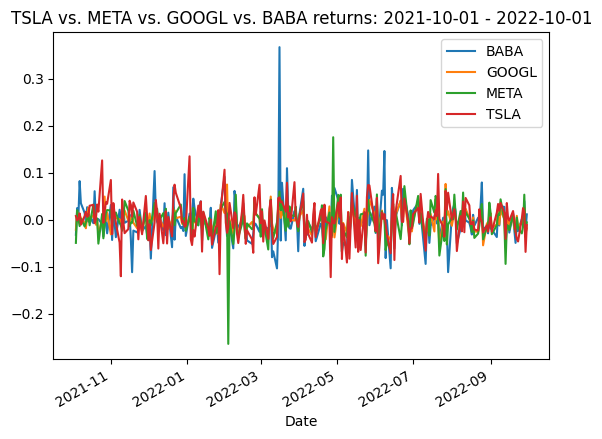

In [51]:
plot_title = f'{" vs. ".join(assets)} returns: {start_date} - {end_date}'
returns.plot(title= plot_title) 

##### Value at risk computation

In [52]:
cov_mat = returns.cov() #historical covariance matrix
chol_mat = np.linalg.cholesky(cov_mat) # Cholesky decomposition
rv = np.random.normal(size=(n_sims, len(assets))) #matrix of random var
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv))) #add correlation to generated random var

r = np.mean(returns, axis=0).values #historical average on assets return
sigma = np.std(returns, axis=0).values # standard dev of assets return
S_0 = adj_close.values[-1, :] # last known stock price
P_0 = np.sum(weight * S_0) # initial portfolio value

In [53]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * correlated_rv)
P_T = np.sum(weight * S_T, axis=1)
P_diff = P_T - P_0

In [54]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 0.81$
1-day VaR with 99.9% confidence: 0.70$
1-day VaR with 99.0% confidence: 0.58$


/tmp/ipykernel_21576/2338619949.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(P_diff, kde=False)


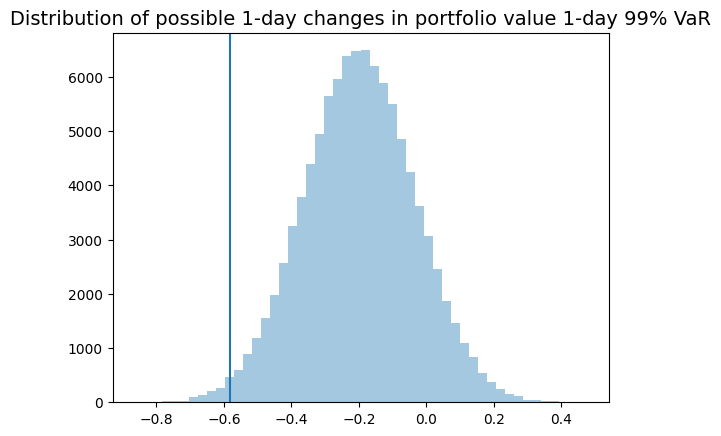

In [55]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 1-day 99% VaR''', fontsize=14)
ax.axvline(var[2], 0, 10000);

#### Efficient frontier

The key framework in asset allocation is the modern portfolio theory (MPT, also known as mean-variance analysis). It was introduced by the Nobel recipient Harry Markowitz and
describes how risk-averse investors can construct portfolios to maximize their expected returns (profits) for a given level of risk. The main insight from MPT is that investors
should not evaluate an asset's performance alone (by metrics such as expected return or volatility), but instead investigate how it would impact the performance of their portfolio of
assets.

According to the Modern Portfolio Theory, the Efficient Frontier is a set of optimal portfolios in the risk-return spectrum. This means that the portfolios on the frontier:
- Offer the highest expected return for a given level of risk
- Offer the lowest level of risk for a given level of expected returns
All portfolios located under the Efficient Frontier curve are considered sub-optimal, so it is
always better to choose the ones on the frontier instead.

##### Base settings

In [56]:
n_days = 252
n_assets = len(assets)

##### Annualized average returns

##### Efficient frontier computation

In [57]:
avg_returns = returns.mean() * n_days
cov_mat = returns.cov() * n_days

In [61]:
#generate random weights
np.random.seed(42) #set fixed seed
weights = np.random.random(size=(n_sims, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

In [62]:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

In [63]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
'volatility': portf_vol,
'sharpe_ratio':
portf_sharpe_ratio})

In [64]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
portf_results_df.returns.max(),
N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)
for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

##### Analyse results

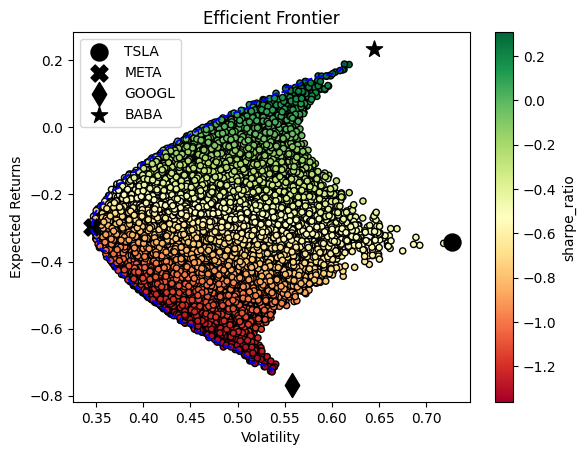

In [70]:
MARKS = ['o', 'X', 'd', '*']
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio', cmap='RdYlGn', edgecolors='black', ax=ax)

ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), y=avg_returns[asset_index], marker=MARKS[asset_index], s=150, color='black', label=assets[asset_index])
ax.legend()

In [74]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [76]:
max_sharpe_portf

returns         0.188722
volatility      0.613237
sharpe_ratio    0.307746
Name: 49990, dtype: float64

In [77]:
min_vol_portf

returns        -0.301458
volatility      0.344658
sharpe_ratio   -0.874658
Name: 14616, dtype: float64

In [78]:
print('Maximum Sharpe ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe ratio portfolio ----
Performance
returns: 18.87% volatility: 61.32% sharpe_ratio: 30.77% 
Weights
TSLA: 0.53% META: 5.40% GOOGL: 1.35% BABA: 92.72% 

In [82]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(assets, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -30.15% volatility: 34.47% sharpe_ratio: -87.47% 
Weights
TSLA: 8.78% META: 90.93% GOOGL: 0.16% BABA: 0.13% 

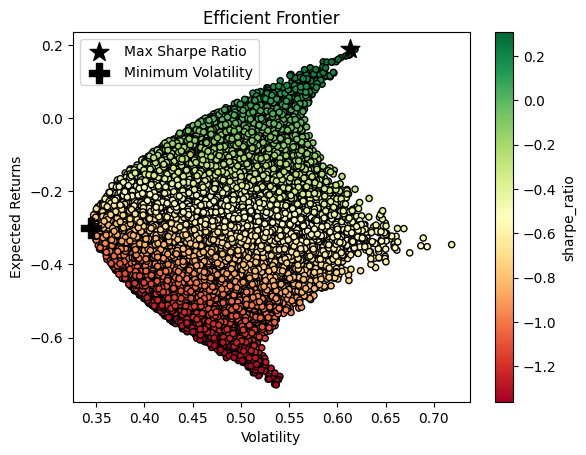

In [83]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
y='returns', c='sharpe_ratio',
cmap='RdYlGn', edgecolors='black',
ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
y=max_sharpe_portf.returns,
c='black', marker='*',
s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
y=min_vol_portf.returns,
c='black', marker='P',
s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',
title='Efficient Frontier')
ax.legend()